# Thesis EDA

Last updated: 03/09/2023


### Research Question and Hypothesis 

**Research question:**

How do buyer preferences change after Covid=19?

**Specific aims:**

1. Assess hedonic model coefficient changes over time. In the hedonic model, independent variables are vectors of attributes related to structural, locational, and neighborhood factors. 
2. Assess Random Forest feature importance changes over time. This approach is robust to spatial autocorrelation, handles interactions between dependent variables better than OLS, and allows for nonlinear relationships.
3. Compare the two approaches and determine which should be used. 

**Hypothesis:**

Neighborhoods matter more after Covid-19 because of the re-conception of the idea of neighborhood.
Increased social stratification across space.


### Contents

1. [Import modules and data](#bullet1)

What's been done so far:
Data joined between sales data and PLUTO data.
Data types cleared up.

2. [EDA and preprocessing](#bullet2)

Visualize univariate dist. (sale price, sale price over time)
Visualize bivariate dist. (sale price x some of the more important predictors based on the lit, colored by time)

Run KMeans to visualize clusters.

(Would I ever want to split into 2 datasets along intrinsic and extrinsic factors and run PCA on each and then compare?)
((Which are the most important features for each group?))

*Train set: first 70% of data points chronologically
*Test set: last whatever % of data points chronologically

3. [Hedonic OLS model (or GMA?)](#bullet3)

This is the traditional model.
Score model, get feature importances.

4. [Random Forest model](#bullet4)

5. [Hedonic model coeffs over time](#bullet5)

6. [Random Forest feature importances over time](#bullet6)

7. [Compare results](#bullet7)



<a class="anchor" id="bullet1"></a>

#### 1. Import modules and data. <a class="anchor" id="bullet1"></a>

[Back to top]<a class="anchor" id="bullet0"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Data/new.csv", index_col=0, low_memory=False)

print("Column counts of each dtype")
print(pd.DataFrame(df.dtypes).sort_values(0)).value_counts()

print("Column names")
list(df.columns)

##### Subset data to include most important features

In [7]:
ex_df = df[['saleprice', 'YEAR BUILT', 'schooldist', 'council', 'policeprct', 'numfloors']]

In [8]:
ex_df.dtypes

saleprice     float64
YEAR BUILT    float64
schooldist    float64
council       float64
policeprct    float64
numfloors     float64
dtype: object

#### 2. EDA and Preprocessing <a class="anchor" id="bullet2"></a>

[Back to top]<a class="anchor" id="bullet0"></a>

In [ ]:
ex_df.describe()

##### Get rid of outliers and missing data

In [ ]:
#MISSING AND ZERO DATA 

missing = pd.DataFrame(ex_df.isna().sum()).rename(columns={0: 'missing_count'})
zeros = pd.DataFrame((ex_df == 0).astype(int).sum(axis=0)).rename(columns={0: 'zero_count'})
problems = pd.concat((missing, zeros), axis=1)
problems['missing_pct'] = problems.missing_count / len(df) * 100
problems['zero_pct'] = problems.zero_count / len(df) * 100
dtypes = list(df.dtypes)
problems['type'] = dtypes

display(problems.sort_values('missing_pct', ascending=False).head(50))

In [11]:
#OUTLIERS: YEAR BUILT

import math

#look at year-built outlier
sub = ex_df[ex_df['YEAR BUILT'] == 1111]
display(sub)

#drop outlier. Commercial garage in Chelsea built in 1111? I think not.
allsales = ex_df[ex_df['YEAR BUILT'] != 1111]

,saleprice,YEAR BUILT,schooldist,council,policeprct,numfloors
978,8208750.0,1111.0,2.0,3.0,13.0,NaN
979,0.0,1111.0,2.0,3.0,13.0,NaN
53869,7680000.0,1111.0,2.0,3.0,13.0,NaN


(110226, 6)
(88224, 6)
proportion missing: 0.199604


In [ ]:
#MISSING: SALE PRICE 

beg = ex_df.shape[0]
print("Starting length: {}".format(beg))
ex_df = ex_df[ex_df['saleprice'] != 0]
ex_df = ex_df[ex_df['saleprice'] != 1]
ex_df = ex_df[ex_df['saleprice'] != math.e]
end = ex_df.shape[[0]]
print("Ending length: {}".format(end))

missing = (beg-end)/beg
print("Percentage missing: {:.3f}".format(missing*100))

##### EDA and visualization

In [ ]:
ex_df.describe()

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

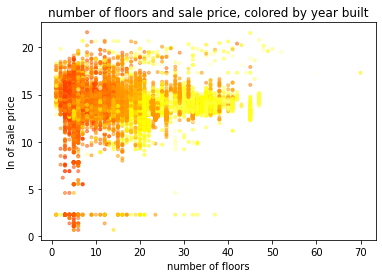

In [14]:
plt.scatter(ex_df.numfloors, np.log(ex_df.saleprice), alpha=0.5, c=np.log(ex_df['YEAR BUILT']), cmap='hot', marker='.')
plt.xlabel("number of floors")
plt.ylabel("ln of sale price")
plt.title("number of floors and sale price, colored by year built")
plt.savefig("Viz_output/floors_and_sale_price.jpg")
plt.show()

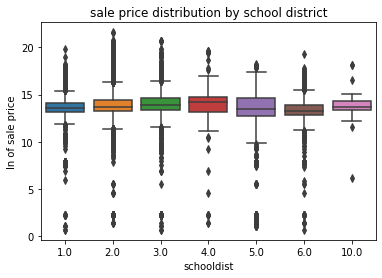

In [15]:
sns.boxplot(x='schooldist', y=np.log(ex_df.saleprice), data=ex_df)
plt.ylabel("ln of sale price")
plt.title("sale price distribution by school district")
plt.savefig("sale_price_and_school_dist.jpg")
plt.show()

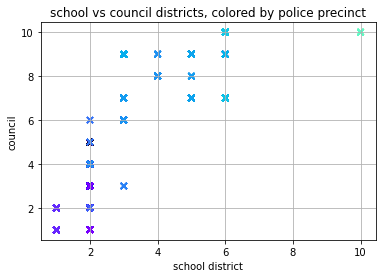

In [16]:
plt.scatter(ex_df.schooldist, ex_df.council, c=ex_df.policeprct, cmap='rainbow', alpha=0.5, marker='x')
plt.grid()
plt.xlabel("school district")
plt.ylabel("council")
plt.title("school vs council districts, colored by police precinct")
plt.savefig("school dist city council dist police prct.jpg")
plt.show()

##### PCA to reduce dimensionality, assess clusters

In [62]:
ex_df_copy = ex_df.copy()

In [63]:
#PCA

from sklearn.decomposition import PCA

#2 PCs
pca = PCA(n_components=2)
pca.fit_transform(preprocessor(ex_df_copy))
print(pca.components_)
print(pca.explained_variance_ratio_)

#to take it from 2 features to 1
pca = PCA(n_components=1)
pca.fit((preprocessor(ex_df_copy)))

X_pca = pca.transform(preprocessor(ex_df_copy)) # create X data with single pca vector
print("original shape:   ", preprocessor(ex_df_copy).shape)
print("transformed shape:", X_pca.shape)

[[ 0.00906578  0.57769554  0.60905136  0.51961539 -0.15887718]
 [ 0.76311237 -0.01855572  0.05803921  0.13183413  0.62973519]]
[0.47449266 0.20577869]
original shape:    (88224, 5)
transformed shape: (88224, 1)


Text(0.5, 1.0, 'Elbow curve')

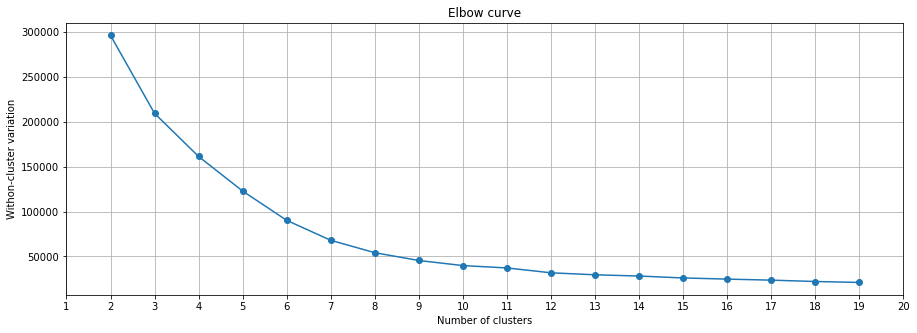

In [57]:
#use an elbow curve to figure out roughly how many clusters to look for
from sklearn.cluster import KMeans

within_cluster_variance = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(preprocessor(ex_df))
    within_cluster_variance.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), within_cluster_variance, marker='o')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.ylabel('Withon-cluster variation')
plt.title('Elbow curve') 

In [60]:
#look at 5 and 7 KMeans clusters
km1 = KMeans(n_clusters=6, random_state=0)
#km2 = KMeans(n_clusters=7, random_state=SEED)

models = [km1] #, km2]

for model in models:
    ex_df['cluster'] = model.fit_predict(preprocessor(ex_df))
    print("KMeans Clusters: "+str(model.n_clusters))
    print("Value counts:")
    print(pd.Series(model.labels_).value_counts())
    print("Inertia: {}".format(model.inertia_))
    display(ex_df.groupby('cluster').mean().sort_values('saleprice', ascending=False))
    print("\n")

KMeans Clusters: 6
Value counts:
0    59501
3    10722
4     9513
1     5110
2     3172
5      206
dtype: int64
Inertia: 90284.12669132356


,saleprice,YEAR BUILT,schooldist,council,policeprct,numfloors
cluster,,,,,,
4,4.637702e+06,1958.371332,2.105723,4.044814,16.667999,24.842111
3,4.342143e+06,1931.031993,1.826991,2.148386,7.935367,9.344310
0,3.888773e+06,1960.304579,2.358996,4.946297,19.699519,11.035582
2,3.122411e+06,0.000000,3.511111,6.066667,20.577778,11.578947
1,2.711904e+06,1925.105242,5.345597,8.845010,30.922114,6.603750
5,6.876060e+05,1975.000000,2.000000,5.000000,114.000000,18.718447


##### Split data into X and y, train test split

In [17]:
y = ex_df['saleprice']
X = ex_df.select_dtypes([np.number]).drop('saleprice', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) #update to go chronologically
X_train.head()

,YEAR BUILT,schooldist,council,policeprct,numfloors
15384,1969.0,3.0,6.0,20.0,32.0
38144,2014.0,NaN,NaN,NaN,NaN
66454,1910.0,2.0,3.0,10.0,5.0
95802,1956.0,6.0,10.0,34.0,6.0
44294,1938.0,2.0,4.0,18.0,17.0


##### Create and fit preprocessing pipeline

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_features = X_train
numeric_features=numeric_features.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

preprocess=preprocessor.fit(X_train) 

def preprocessor(data):
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data

#### 3. Hedonic (OLS) model<a class="anchor" id="bullet3"></a>

[Back to top]<a class="anchor" id="bullet0"></a>

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(preprocessor(X_train), y_train)

print("Train set score: {}".format(lr.score(preprocessor(X_train), y_train)))
print("Mean cross-val score for train set: {}".format(cross_val_score(lr, preprocessor(X_train), y_train, scoring='mean_squared_error').mean()))
print("Test set score: {}.".format(lr.score(preprocessor(X_test), y_test)))

#### 4. Random Forest model<a class="anchor" id="bullet4"></a>

[Back to top]<a class="anchor" id="bullet0"></a>

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from statistics import mean

forest = RandomForestRegressor()

forest.fit(preprocessor(X_train),y_train)

print("Train set score: {}".format(forest.score(preprocessor(X_train), y_train)))
print("Mean cross-val score for train set: {}".format(cross_val_score(forest, preprocessor(X_train), y_train, scoring='mean_squared_error').mean()))
print("Test set score: {}.".format(forest.score(preprocessor(X_test), y_test)))

Train set score: 0.5423446311100677
Test set score: 0.272763304972064.


In [45]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

grid = GridSearchCV(RandomForestRegressor(), param_grid = param_grid, cv=10)

grid.fit(preprocessor(X_train), y_train)

print("best median cross-val score: {}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {}".format(grid.score(preprocessor(X_test), y_test)))

#view results
results = pd.DataFrame(grid.cv_results_)
results

KeyboardInterrupt: 

In [ ]:
#pull out best hyperparams

best_bootstrap = grid.best_params_['bootstrap']
best_max_depth = grid.best_params_['max_depth']
best_max_features = grid.best_params_['max_features']
best_min_samples_leaf = grid.best_params_['min_samples_leaf']
best_min_samples_split = grid.best_params_['min_samples_split']
best_n_estimators = grid.best_params_['n_estimators']

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

best_forest = RandomForestRegressor(bootstrap = best_bootstrap,
                                    max_depth = best_max_depth,
                                    max_feature = best_max_features,
                                    min_samples_leaf = best_min_samples_leaf,
                                    min_samples_split = best_min_samples_split,
                                    n_estimators = best_n_estimators).fit(preprocessor(X_train), y_train)
print("train set mean cross val score: {}".format(cross_val_score(best_forest, preprocessor(X_train), y_train, scoring='mean_squared_error').mean()))
print("test set score: {}".format(best_forest.score(preprocessor(X_test), y_test)))

#use best params to run forest and get feature importances

plt.title("feature importances")
plt.bar(X_train.columns, best_forest.feature_importances_)
plt.show()